In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings

Preparation de donnees


In [12]:
warnings.filterwarnings('ignore')

# 1. Chargement des données
df = pd.read_csv('Prediction_duree_completion_formations.csv')

# Affichage des premières lignes du dataset
print("\n=== Aperçu des données ===\n")
print(df.head())

# Informations sur le dataset
print("\n=== Informations sur le dataset ===\n")
print(f"Nombre d'échantillons: {df.shape[0]}")
print(f"Nombre de caractéristiques: {df.shape[1]}")
print("\nTypes de données:")
print(df.dtypes)

# Statistiques descriptives
print("\n=== Statistiques descriptives ===\n")
print(df.describe())

# Vérification des valeurs manquantes
print("\n=== Vérification des valeurs manquantes ===\n")
print(df.isnull().sum())
print("\n=== Vérification des valeurs duplicées ===\n")
print(df.duplicated().sum())

# 2. Prétraitement des données
print("\n=== Prétraitement des données ===\n")

# Séparation des caractéristiques et de la cible
X = df.drop(['Étudiant_ID', 'Durée_Formation_Réelle'], axis=1)
y = df['Durée_Formation_Réelle']

# Identification des colonnes numériques et catégorielles
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Caractéristiques numériques: {num_features}")
print(f"Caractéristiques catégorielles: {cat_features}")

# Création d'un préprocesseur pour les données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ])


=== Aperçu des données ===

   Étudiant_ID  Âge Niveau_Éducation  Expérience_Formation  \
0            1   40         Doctorat                    12   
1            2   22          Licence                    18   
2            3   18           Master                     9   
3            4   36         Doctorat                     6   
4            5   27     Baccalauréat                    14   

   Heures_Étude_Par_Semaine  Note_Moyenne_Antérieure Difficulté_Formation  \
0                        15                      4.4            Difficile   
1                        22                      2.3                Moyen   
2                         6                      3.3            Difficile   
3                        30                      4.8               Facile   
4                        26                      2.0            Difficile   

   Durée_Formation_Prévue  Durée_Formation_Réelle  
0                       6                       9  
1                       7      

Taille de l'ensemble d'entraînement: (800, 7)
Taille de l'ensemble de test: (200, 7)


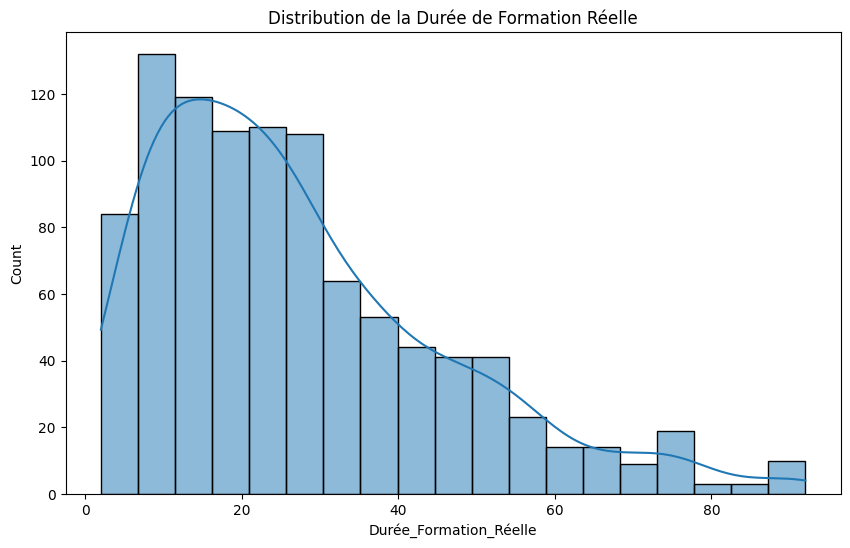

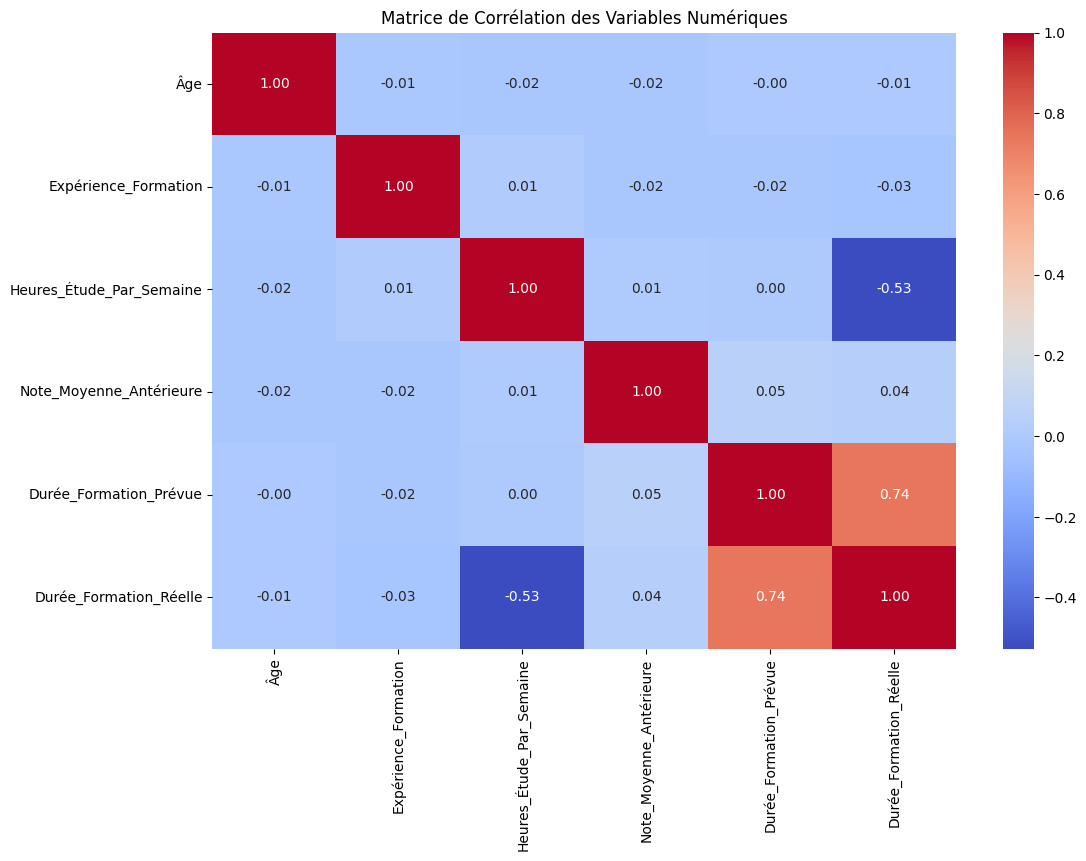

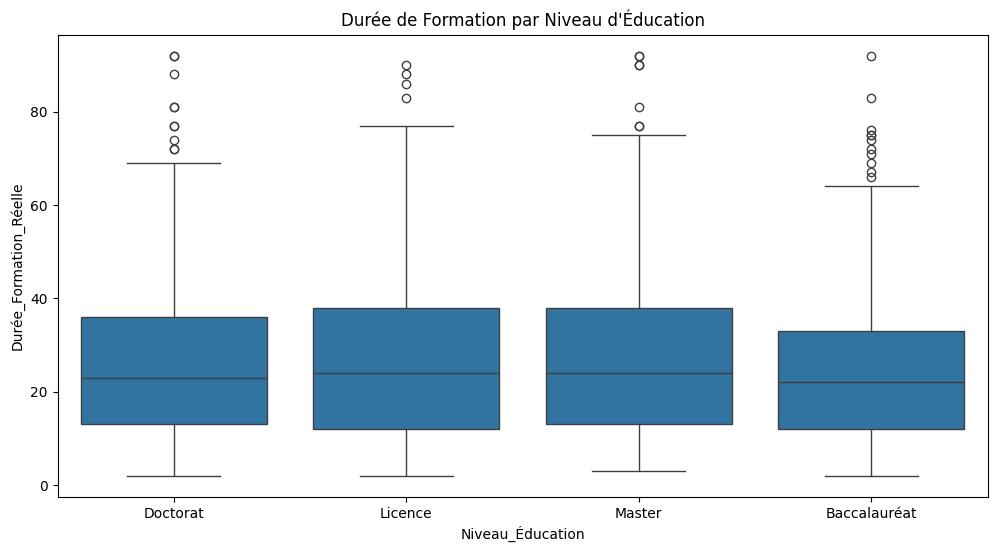

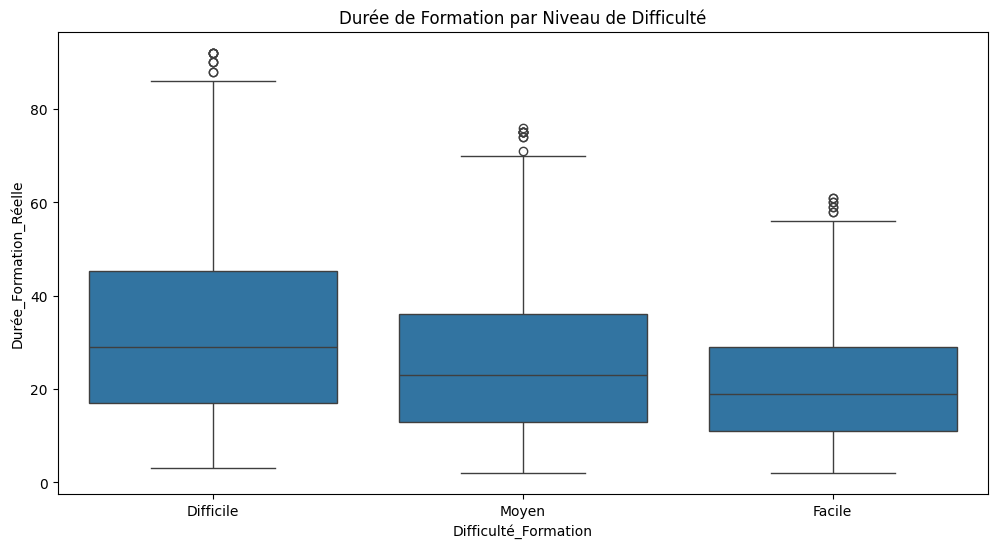

In [13]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape}")
print(f"Taille de l'ensemble de test: {X_test.shape}")

# Visualisation de la distribution de la variable cible
plt.figure(figsize=(10, 6))
sns.histplot(df['Durée_Formation_Réelle'], kde=True)
plt.title('Distribution de la Durée de Formation Réelle')
plt.savefig('distribution_duree_reelle.png')

# Visualisation des corrélations entre variables numériques
plt.figure(figsize=(12, 8))
corr_matrix = df[num_features + ['Durée_Formation_Réelle']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de Corrélation des Variables Numériques')
plt.savefig('correlation_matrix.png')

# Visualisation de la relation entre variables catégorielles et la cible
plt.figure(figsize=(12, 6))
sns.boxplot(x='Niveau_Éducation', y='Durée_Formation_Réelle', data=df)
plt.title('Durée de Formation par Niveau d\'Éducation')
plt.savefig('duree_par_niveau_education.png')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Difficulté_Formation', y='Durée_Formation_Réelle', data=df)
plt.title('Durée de Formation par Niveau de Difficulté')
plt.savefig('duree_par_difficulte.png')

# Fonction pour convertir les prédictions continues en classes binaires
def convert_to_binary(y_true, y_pred, threshold=None):
    if threshold is None:
        threshold = np.median(y_true)  # Utiliser la médiane comme seuil par défaut

    y_true_binary = (y_true > threshold).astype(int)
    y_pred_binary = (y_pred > threshold).astype(int)

    return y_true_binary, y_pred_binary

# Fonction pour calculer les métriques de classification
def calculate_classification_metrics(y_true, y_pred):
    y_true_binary, y_pred_binary = convert_to_binary(y_true, y_pred)

    # Calcul des métriques
    acc = accuracy_score(y_true_binary, y_pred_binary)
    prec = precision_score(y_true_binary, y_pred_binary)
    rec = recall_score(y_true_binary, y_pred_binary)
    spec = specificity_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)

    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'Specificity': spec,
        'F1-Score': f1
    }

# Fonction pour calculer la spécificité
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Fonction pour évaluer les modèles de régression
def evaluate_regression_model(model, X_train, X_test, y_train, y_test):
    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédictions
    y_pred = model.predict(X_test)

    # Métriques de régression
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Métriques de classification (en convertissant les prédictions continues en binaires)
    class_metrics = calculate_classification_metrics(y_test, y_pred)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        **class_metrics
    }

In [14]:
# 3. Modélisation et évaluation
print("\n=== Modélisation et évaluation ===\n")

# Création des pipelines pour chaque modèle
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor())
])

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR())
])

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Paramètres pour la recherche par grille
knn_params = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

svm_params = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto', 0.1, 0.01]
}

dt_params = {
    'model__max_depth': [None, 5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Optimisation des hyperparamètres avec GridSearchCV
knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5, scoring='neg_mean_squared_error')
knn_grid.fit(X_train, y_train)

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring='neg_mean_squared_error')
svm_grid.fit(X_train, y_train)

dt_grid = GridSearchCV(dt_pipeline, dt_params, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train, y_train)

# Meilleurs paramètres pour chaque modèle
print("\n=== Meilleurs paramètres ===\n")
print(f"KNN: {knn_grid.best_params_}")
print(f"SVM: {svm_grid.best_params_}")
print(f"Decision Tree: {dt_grid.best_params_}")


=== Modélisation et évaluation ===


=== Meilleurs paramètres ===

KNN: {'model__n_neighbors': 5, 'model__p': 2, 'model__weights': 'distance'}
SVM: {'model__C': 100, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Decision Tree: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}


In [15]:
# Évaluation des modèles optimisés
knn_best = knn_grid.best_estimator_
svm_best = svm_grid.best_estimator_
dt_best = dt_grid.best_estimator_

knn_metrics = evaluate_regression_model(knn_best, X_train, X_test, y_train, y_test)
svm_metrics = evaluate_regression_model(svm_best, X_train, X_test, y_train, y_test)
dt_metrics = evaluate_regression_model(dt_best, X_train, X_test, y_train, y_test)


=== Benchmarking des modèles ===

                     MSE      RMSE       MAE        R2  Accuracy  Precision  \
KNN            37.455961  6.120128  4.448716  0.880833     0.915   0.882353   
SVM             4.207664  2.051259  1.379385  0.986613     0.960   0.939394   
Decision Tree   5.647917  2.376535  1.659167  0.982031     0.950   0.938144   

                 Recall  Specificity  F1-Score  
KNN            0.947368     0.885714  0.913706  
SVM            0.978947     0.942857  0.958763  
Decision Tree  0.957895     0.942857  0.947917  

Le meilleur modèle selon R² est: SVM

=== Analyse des résultats ===

Le modèle SVM a obtenu les meilleures performances globales.
R² Score: 0.9866
RMSE: 2.0513
Accuracy: 0.9600
F1-Score: 0.9588

Forces et faiblesses des modèles:
KNN: Simple et efficace pour les relations non linéaires, mais sensible à l'échelle des données et moins performant avec de nombreuses dimensions.
SVM: Bonne généralisation et efficace dans les espaces de grande dimension,

<Figure size 1400x800 with 0 Axes>

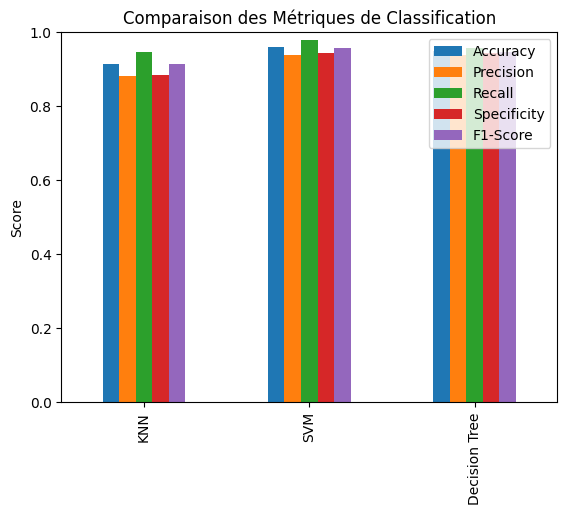

<Figure size 1400x800 with 0 Axes>

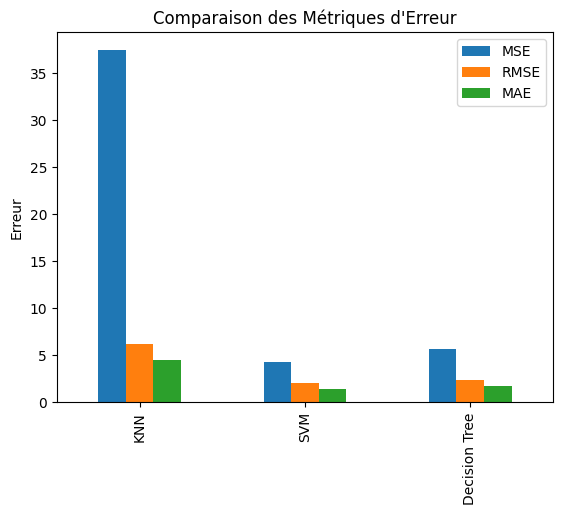

<Figure size 1000x600 with 0 Axes>

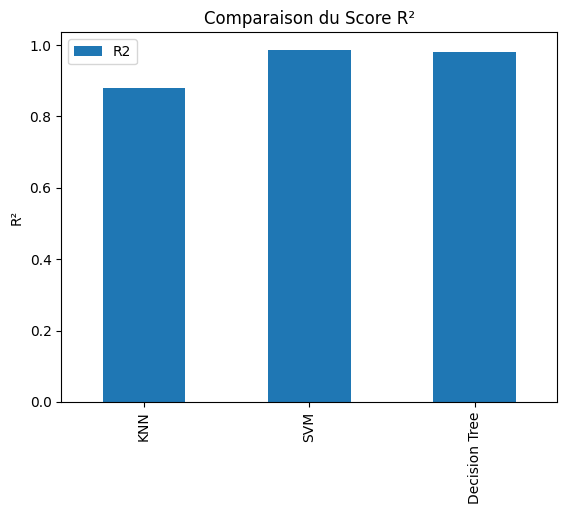

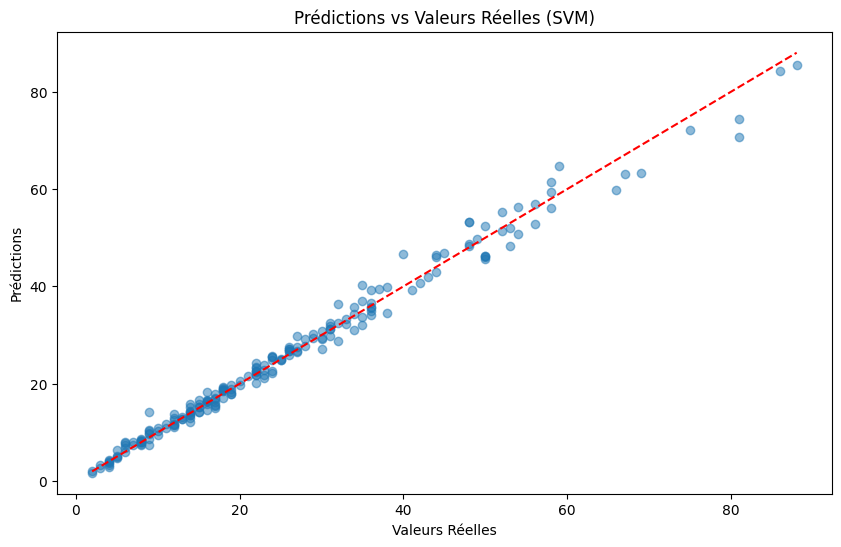

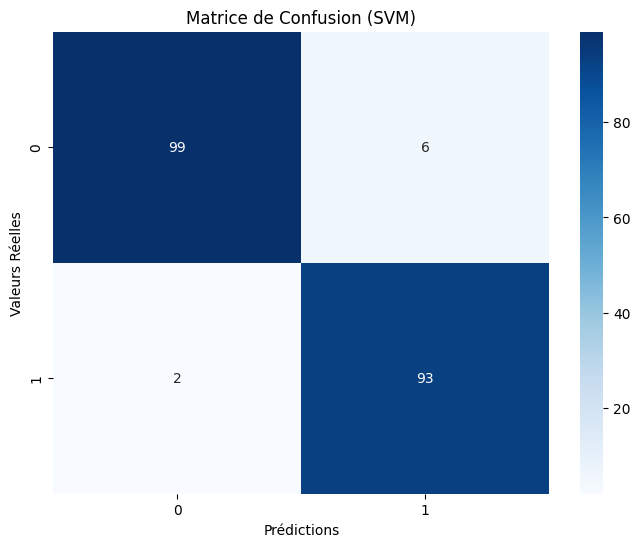

In [16]:
# 4. Benchmarking des modèles
print("\n=== Benchmarking des modèles ===\n")

# Création d'un DataFrame pour comparer les performances
models = ['KNN', 'SVM', 'Decision Tree']
metrics_df = pd.DataFrame({
    'KNN': knn_metrics,
    'SVM': svm_metrics,
    'Decision Tree': dt_metrics
}).T

print(metrics_df)

# Visualisation des performances des modèles
plt.figure(figsize=(14, 8))
metrics_df[['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']].plot(kind='bar')
plt.title('Comparaison des Métriques de Classification')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.savefig('comparaison_metriques_classification.png')

plt.figure(figsize=(14, 8))
metrics_df[['MSE', 'RMSE', 'MAE']].plot(kind='bar')
plt.title('Comparaison des Métriques d\'Erreur')
plt.ylabel('Erreur')
plt.savefig('comparaison_metriques_erreur.png')

plt.figure(figsize=(10, 6))
metrics_df[['R2']].plot(kind='bar')
plt.title('Comparaison du Score R²')
plt.ylabel('R²')
plt.savefig('comparaison_r2.png')

# Visualisation des prédictions vs valeurs réelles pour le meilleur modèle
best_model_name = metrics_df['R2'].idxmax()
print(f"\nLe meilleur modèle selon R² est: {best_model_name}")

if best_model_name == 'KNN':
    best_model = knn_best
elif best_model_name == 'SVM':
    best_model = svm_best
else:
    best_model = dt_best

y_pred = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title(f'Prédictions vs Valeurs Réelles ({best_model_name})')
plt.savefig('predictions_vs_reelles.png')

# Matrice de confusion pour le meilleur modèle
y_test_binary, y_pred_binary = convert_to_binary(y_test, y_pred)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title(f'Matrice de Confusion ({best_model_name})')
plt.savefig('matrice_confusion.png')

print("\n=== Analyse des résultats ===\n")
print(f"Le modèle {best_model_name} a obtenu les meilleures performances globales.")
print(f"R² Score: {metrics_df.loc[best_model_name, 'R2']:.4f}")
print(f"RMSE: {metrics_df.loc[best_model_name, 'RMSE']:.4f}")
print(f"Accuracy: {metrics_df.loc[best_model_name, 'Accuracy']:.4f}")
print(f"F1-Score: {metrics_df.loc[best_model_name, 'F1-Score']:.4f}")

print("\nForces et faiblesses des modèles:")
print("KNN: Simple et efficace pour les relations non linéaires, mais sensible à l'échelle des données et moins performant avec de nombreuses dimensions.")
print("SVM: Bonne généralisation et efficace dans les espaces de grande dimension, mais plus lent à entraîner et sensible au choix des hyperparamètres.")
print("Decision Tree: Facile à interpréter et capable de capturer des relations non linéaires, mais tendance au surapprentissage.")

print("\nConclusion:")
print(f"Le modèle {best_model_name} est recommandé pour le déploiement en raison de ses performances supérieures sur les métriques clés.")